# Simon's Algorithm

The Simon's algorithm [[1](#SimonsWiki)] is one of the basic quantum algorithms that demonstrates an exponential speed-up over its classical counterpart, in the oracle complexity setting. The algorithm solves the so called Simon's problem: 

* **Input:** A function $f: [0,1]^N \rightarrow [0,1]^N$.

* **Promise:**  There is a secret binary string $s$ such that
$$
f(x) = f(y) \iff x\oplus  y \in \{0, s\},
\tag{1}
$$
where $\oplus$ is a bitwise xor operation.

* **Output:** The secret string $s$, using a minimal number of queries of $f$.

*** 


Note that the condition on $f$ implies that it is 2-to-1 if $s \neq 0^N$, and 1-to-1 otherwise. Herefter we refer to a function $f(x)$ that satisfies the condition in Eq. ([1](#mjx-eqn-1)) as a "Simon's function".

Problem hardeness: The Simon's problem is hard to solve with a classical, deterministic or probabalistic, approaches. This can be understood as follows: determining $s$ requries finding a collision $f(x)=f(y)$, as $s = x\oplus y$. What is the minimal number of calls for measuring a collision? If we take the deterministic approach, in the worst case we will need $2^{N-1}$ calls. A probablistic approach, in the spirit of the one that solves the Birthday problem [[2](#BDWiki)], has a slightly better scaling of $O(2^{N/2})$ queries.

**The quantum approach requires $O(N)$ queries, thus, introducing an exponential speedup**.

Next, we define the Simon's algorithm, which has a [quantum part](#The-Quantum-Part) and a [classical postprocess part](#The-Classical-Postprocess). Then, we run the algorithm on two different examples of a Simon's function: one that can be defined with [simple arithmetic](#Example:-Arithmetic-Simon's-Function), and another that has a [shallow implementation](#Example:-Shallow-Simon's-Function). A [mathematical explanation](#Technical-Notes) of the algorithm is provided at the end of this notebook.

<center>
<img src="https://docs.classiq.io/resources/simons_algorithm.png" style="width:80%">
<figcaption align = "middle"> Figure 1. The Simon's algorithm is comprised of two quantum blocks. The main part of the algorithm
is the oracle which implements the Simon's function f(x). </figcaption>
</center>

## How to Build the Algorithm with Classiq

### The Quantum Part

The quantum part of the algorithm is rather simple, calling the quantum implementation of $f(x)$, between two calls of the hadamard transform. The call of $f$ is done out-of-place, onto a quantum variable $y$, whereas only the final state of $x$ is relevant to the classical post-process to follow. 

In [1]:
from classiq import Output, QCallable, QNum, allocate_num, hadamard_transform, qfunc


@qfunc
def simon_qfunc(f_qfunc: QCallable[QNum, Output[QNum]], x: QNum):

    res = QNum("res")
    hadamard_transform(x)
    f_qfunc(x, res)
    hadamard_transform(x)

### The Classical Postprocess

The classical part of the algorithm includes the following post-processing steps:
1. Finding $N-1$ samples of $x$ that are linearly independent, $\{y_k\}^{n-1}_{1}$. It is gurenteed that this can be acheived with high probability, see the [technical details](#The-classical-part) below.
2. Finding the string $s$ such that $s \cdot y_k=0 \,\,\, \forall k$, where $\cdot$ refers to a dot-product mod 2 (polynomial complexity in $N$).

For these steps we use the *Galois* package, which extends *numpy* to finite field operations.

In [2]:
# !pip install galois

In [3]:
import galois
import numpy as np

# here we work over boolean arithmetics - F(2)
GF = galois.GF(2)

We define two classical functions for the first step: 

In [4]:
# The following function checks whether a set contains linearly independet vectors


def is_independent_set(vectors):
    matrix = GF(vectors)
    rank = np.linalg.matrix_rank(matrix)
    if rank == len(vectors):
        return True
    else:
        return False


def get_independent_set(samples):
    """
    The following function gets samples of n-sized strings from running the quantum part and return an n-1 x n matrix,
    whose rows forms a set if independent
    """
    ind_v = []
    for v in samples:
        if is_independent_set(ind_v + [v]):
            ind_v.append(v)
            if len(ind_v) == len(v) - 1:
                # reached max set of N-1
                break
    return ind_v

For the second step we simply need to solve a linear set of equations. We have $N-1$ equations on a binary vector of size $N$.
It has two solutions, one of them is the trivial solution $0^N$, and the other gives us the secret string $s$. The *Galois* package handles this task as follows:

In [5]:
def get_secret_integer(matrix):

    gf_v = GF(matrix)  # converting to a matrix over Z_2
    null_space = gf_v.T.left_null_space()  # finding the right-null space of the matrix
    return int(
        "".join(np.array(null_space)[0][::-1].astype(str)), 2
    )  # converting from binary to integer

---

Next we provide two different examples of Simon's function, and run the Simon's algorithm to find their secret string.

---

## Example: Arithmetic Simon's Function

An example of a valid $f(x)$ function that satisfies the condition in Eq. ([1](#mjx-eqn-1)) is:
$$
f(x) = \min(x, x\oplus s).
$$
Clearly, we have that $f(x\oplus s) = \min(x\oplus s, (x\oplus s)\oplus s)=\min(x\oplus s, x)=f(x)$.

### Implementing of the Simon's Function

We define the function, as well as a model that applies it on all computational basis states to illustrate that it is a two-to-one function.

In [6]:
from classiq import CInt, Output, QNum, create_model, hadamard_transform, qfunc
from classiq.qmod.symbolic import min


@qfunc
def simon_qfunc_simple(s: CInt, x: QNum, res: Output[QNum]):
    res |= min(x, x ^ s)

Let us run it with $N=5$ and $s={'}00110{'} (\equiv 6)$, starting with a uniform distribution of $|x\rangle$ over all possible states:

In [7]:
from classiq import Constraints, allocate, execute, show, synthesize

NUM_QUBITS = 5
S_SECRET = 6


@qfunc
def main(x: Output[QNum], res: Output[QNum]):
    allocate(NUM_QUBITS, x)
    hadamard_transform(x)
    simon_qfunc_simple(S_SECRET, x, res)


qmod = create_model(main, constraints=Constraints(optimization_parameter="width"))

# synthesize
qprog = synthesize(qmod)

# vizualize
show(qprog)

# execute
result = execute(qprog).result()

Opening: https://platform.classiq.io/circuit/c564b853-0e0c-46ee-b196-bbb8e43db55c?version=0.45.0.dev0%2Bcf1b9b7ccc


By plotting the results we can see that this is two-to-one function:

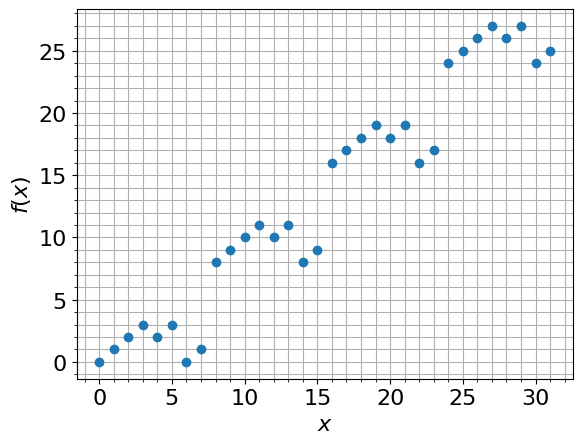

In [8]:
import matplotlib.pyplot as plt

my_result = {
    sample.state["x"]: sample.state["res"] for sample in result[0].value.parsed_counts
}
fig, ax = plt.subplots()
ax.plot(my_result.keys(), my_result.values(), "o")
ax.grid(axis="y", which="minor")
ax.grid(axis="y", which="major")
ax.grid(axis="x", which="minor")
ax.grid(axis="x", which="major")
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()

### Running the Simon's Algorithm

Taking $N$ number of shots gurentees getting a set of $N-1$ independet strings with high probability (assuming a noiseless quantum computer), see [technical explanation](#The-quantum-part) below. Moreover, increasing the number of shots by a constant factor provides an exponential improvment. Below we take $50*N$ shots.

In [9]:
from classiq import allocate_num
from classiq.execution import ExecutionPreferences


@qfunc
def main(x: Output[QNum]):

    allocate(NUM_QUBITS, x)
    simon_qfunc(lambda x, res: simon_qfunc_simple(S_SECRET, x, res), x)


qmod = create_model(
    main,
    constraints=Constraints(optimization_parameter="width"),
    execution_preferences=ExecutionPreferences(num_shots=50 * NUM_QUBITS),
)

In [10]:
from classiq import write_qmod

write_qmod(qmod, "simon_example")

We Synthesize and execute to obtain the results 

In [11]:
qprog = synthesize(qmod)
result = execute(qprog).result()
samples = [
    [int(k) for k in key] for key in result[0].value.counts_of_output("x").keys()
]

In [12]:
matrix_of_ind_v = get_independent_set(samples)
assert (
    len(matrix_of_ind_v) == NUM_QUBITS - 1
), "Failed to find an independent set, try to increase the number of shots"
quantum_secret_integer = get_secret_integer(matrix_of_ind_v)

In [13]:
print("The secret binary string (integer) of f(x):", S_SECRET)
print("The result of the Simon's Algorithm:", quantum_secret_integer)
assert (
    S_SECRET == quantum_secret_integer
), "The Simon's algorithm failed to find the secret key."

The secret binary string (integer) of f(x): 6
The result of the Simon's Algorithm: 6


## Example: Shallow Simon's Function

In the second example we take a Simon's function that was presented in a recent paper [[3](#SimonsPaper2024)]: Take a secret string of the form $s=0^{N-L}1^L = \underbrace{00\dots0}_{N-L}\underbrace{1\dots111}_{L}$, and define the 2-to-1 function:
$$
f_{s}(|x\rangle_N) = \underbrace{|x_0\rangle |x_1\rangle \dots |x_{N-L-1}\rangle}_{N-L} |0\rangle \underbrace{|x_{N-L+1}\oplus x_{N-L}\rangle \dots |x_{N-1}\oplus x_{N-L}\rangle}_{L-1}.
$$
The function $f$ operates as follows: for the first $N-L$ elements we simply "copy" the data, whereas for the last $L$ elements we apply a xor with the $N-L$ element. A simple proof that this is indeed a 2-to-1 function is given in Ref. [[3](#SimonsPaper2024)].

*Comment:* Ref. [[3](#SimonsPaper2024)] employed further reduction of the function implementation (reducing the $N$-sized Simon's problem to an $(N-L)$-sized problem), added a classical post-process of randomly permutating over the result of $f(x)$ to increase the hardness of the problem, as well as included some NISQ analysis. These steps where taken to show an algorithmic speedup on real quantum hardware.

### Implementing of the Simon's Function

The first $N-L$ "classical copies", $|x_k,0\rangle\rightarrow |x_k x_k\rangle$, can be implemented by $CX$ gates. The xor operations, $|x_k,0\rangle\rightarrow |x_k, x_k \oplus x_{N-L}\rangle$, can be implemented by two CX operations, one for a "classical copy" of $x_k$, followed by a $CX$ operation to apply a xor with $x_{N-L}$.

In [14]:
from classiq import CX, QArray, QBit, repeat


@qfunc
def simon_qfunc_with_bipartite_s(
    partition_index: CInt, x: QArray[QBit], res: Output[QArray[QBit]]
):

    allocate(x.len, res)

    repeat(x.len - partition_index, lambda i: CX(x[i], res[i]))
    repeat(
        partition_index - 1,
        lambda i: (
            CX(
                x[x.len - partition_index + 1 + i],
                res[x.len - partition_index + 1 + i],
            ),
            CX(x[x.len - partition_index], res[x.len - partition_index + 1 + i]),
        ),
    )

Below we take a specific example, and plot $f(x)$ for all possible $x$ values: 

Opening: https://platform.classiq.io/circuit/50ef7799-86ce-401b-a6d9-f6fea15c01ab?version=0.45.0.dev0%2Bcf1b9b7ccc


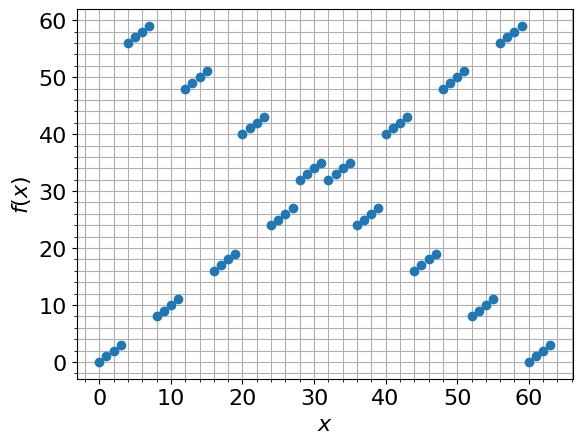

In [15]:
NUM_QUBITS = 6
PARTITION_INDEX = 4


@qfunc
def main(x: Output[QNum], res: Output[QNum]):
    allocate(NUM_QUBITS, x)
    hadamard_transform(x)
    simon_qfunc_with_bipartite_s(PARTITION_INDEX, x, res)


qmod = create_model(main, constraints=Constraints(optimization_parameter="width"))

# synthesize
qprog = synthesize(qmod)

# vizualize
show(qprog)

# execute
result = execute(qprog).result()

# plot the f(x)
my_result = {
    sample.state["x"]: sample.state["res"] for sample in result[0].value.parsed_counts
}
fig, ax = plt.subplots()
ax.plot(my_result.keys(), my_result.values(), "o")
ax.grid(axis="y", which="minor")
ax.grid(axis="y", which="major")
ax.grid(axis="x", which="minor")
ax.grid(axis="x", which="major")
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()

### Running the Simon's Algorithm

As in the first example, we take $50*N$ shots.

In [16]:
@qfunc
def main(x: Output[QNum]):

    allocate(NUM_QUBITS, x)
    simon_qfunc(lambda x, res: simon_qfunc_with_bipartite_s(PARTITION_INDEX, x, res), x)


qmod = create_model(
    main, execution_preferences=ExecutionPreferences(num_shots=50 * NUM_QUBITS)
)

write_qmod(qmod, "simon_shallow_example")

We synthesize and execute to obtain the results 

In [17]:
qprog = synthesize(qmod)
show(qprog)
result = execute(qprog).result()
samples = [
    [int(k) for k in key] for key in result[0].value.counts_of_output("x").keys()
]

Opening: https://platform.classiq.io/circuit/d2d0d63d-ab91-408e-8e87-3c5a115b31c8?version=0.45.0.dev0%2Bcf1b9b7ccc


In [18]:
matrix_of_ind_v = get_independent_set(samples)
assert (
    len(matrix_of_ind_v) == NUM_QUBITS - 1
), "Failed to find an independent set, try to increase the number of shots"
quantum_secret_integer = get_secret_integer(matrix_of_ind_v)

In [19]:
s_secret = int("1" * PARTITION_INDEX + "0" * (NUM_QUBITS - PARTITION_INDEX), 2)
print("The secret binary string (integer) of f(x):", s_secret)
print("The result of the Simon's Algorithm:", quantum_secret_integer)
assert (
    s_secret == quantum_secret_integer
), "The Simon's algorithm failed to find the secret key."

The secret binary string (integer) of f(x): 60
The result of the Simon's Algorithm: 60


## Technical Notes

Below we provide some technical details about the quantum and classical parts of the Simon's algorithm

### The Quantum Part

Following the three blocks of the algorithm:
$$
|0\rangle_N |0\rangle_N \rightarrow \frac{1}{2^{N/2}}\sum^{2^N-1}_{x=0}|x\rangle_N |0\rangle_N  \rightarrow \frac{1}{2^{N/2}}\sum^{2^N-1}_{x=0}|x\rangle_N |f(x)\rangle_N 
 \rightarrow \frac{1}{2^{N}} \sum^{2^N-1}_{y=0} |y\rangle_N \left( \sum^{2^N-1}_{x=0}(-1)^{x\cdot y} |f(x)\rangle_N \right),
$$
and we measure the first register $|y\rangle$. First, we treat the case that $f(x)$ is a 2-to-1 function. The claim is that for any measured state $y$, we must have that $y\cdot s=0$. To see this, calculate the probability of measuring some state $|y\rangle$:
$$
P(|y\rangle) \propto \left| \sum^{2^N-1}_{x=0}(-1)^{x\cdot y} |f(x)\rangle_N \right|^2.
$$
Now, change the sum to run over the image of $f(x)$ instead of over all $x\in [0,2^{N}-1]$. Since for any $f(x)$ there are two sources in the domain, $x$ and $x\oplus s$,  we can write
$$
P(|y\rangle) \propto \left| \sum_{f(x) \in imag(f)} \left[ (-1)^{x\cdot y} + (-1)^{(x\oplus s )\cdot y} \right]|f(x)\rangle_N \right|^2.
$$
Finally, if we assume by negation that  $y\cdot s =1$ then the above expression is evaluted to zero, and we get a contradiction that $y$ was measured.
Hence, for any measured $y$ we have $y\cdot s =0$.

If $s=0^N$, we still measure a set of $N-1$ independent $y$ with high probability (each $y$ with $1/2^N$ probability).

### The Classical Part

We have a set of possible $y$ values that can be measured, each with the same probability of $1/M$, where $M$ is the set size. In the case that $s=0^N$ we have $M=2^N$, whereas for $s\neq 0^N$ the set size is $M=2^{N-1}$. The probability to measure a set of $N-1$ linearly independent binary strings $y$ can be calculated as follows (see also the Birthday problem [[2](#BDWiki)]): For the first string we just require that we do not pick $y=0^N$, so $P(y_0)=1-1/M$. Then, for the next string, we require that it is not in $\left\{a_0 y_0\,\,\,| a_0=0,1\right\}$, thus $P(y_1)=(1-2/M)$. The following string is required not to be picked out of $\left\{a_0 y_0+a_1y_1\,\,\,| a_0, a_1=0,1\right\}$. We can continue with this procedure up to $y_{N-1}$ to get
$$
P_{\rm independent} = 
\left\{\begin{array}{l l}
\Pi^{2^{N-2}}_{k=0} \left(1-2^k/2^{N}\right) & \text{,  if } f(x) \text{ is 1-to-1},\\
\Pi^{2^{N-2}}_{k=0} \left(1-2^k/2^{N-1}\right) & \text{,   if } f(x) \text{ is 2-to-1}
\end{array}
\,\,\,\,\,
\geq \Pi^{\infty}_{k=1}\left(1-\frac{1}{2^k}\right) \approx 0.2887 \geq 1/4.
\right.
$$
If we repeat the experiment $K$ times then the probability to measure an independent set improves exponentially.

## References

<a id='SimonsWiki'>[1]</a>: [Simon's algorithm (Wikipedia)](https://en.wikipedia.org/wiki/Simon%27s_problem)

<a id='BDWiki'>[2]</a>: [Birthday problem (Wikipedia)](https://en.wikipedia.org/wiki/Birthday_problem)

<a id='SimonsPaper2024'>[3]</a>: [Singkanipa P., et al. "Demonstration of Algorithmic Quantum Speedup for an Abelian Hidden Subgroup Problem." arXiv preprint arXiv:2401.07934 (2024).](https://arxiv.org/abs/2401.07934)